In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import lightgbm as lgbm
import pickle
import joblib

C:\Users\Munj Patel\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
plt.rcParams['figure.figsize'] = 13,13
sns.set_style('darkgrid')
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv(r"C:\Users\Munj Patel\Downloads\insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86


In [4]:
df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
expenses    float64
dtype: object

In [5]:
df.shape

(1338, 7)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   expenses  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [7]:
df.describe()

,age,bmi,children,expenses
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.665471,1.094918,13270.422414
std,14.049960,6.098382,1.205493,12110.011240
min,18.000000,16.000000,0.000000,1121.870000
25%,27.000000,26.300000,0.000000,4740.287500
50%,39.000000,30.400000,1.000000,9382.030000
75%,51.000000,34.700000,2.000000,16639.915000
max,64.000000,53.100000,5.000000,63770.430000


In [8]:
df.describe(include = ['O'])

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


In [9]:
df['age'] = df['age']/10
df['bmi'] = df['bmi']/10
df['expenses'] = df['expenses']/10000

In [10]:
df[df.duplicated()]

,age,sex,bmi,children,smoker,region,expenses
581,1.9,male,3.06,0,no,northwest,0.163956


In [11]:
df = df.drop_duplicates().reset_index(drop = True)

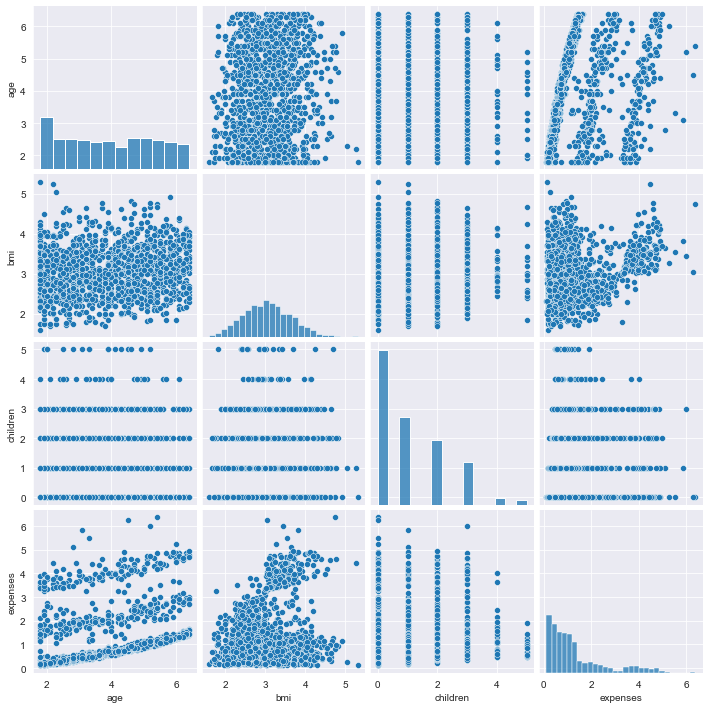

In [12]:
sns.pairplot(df)

### Continuous 

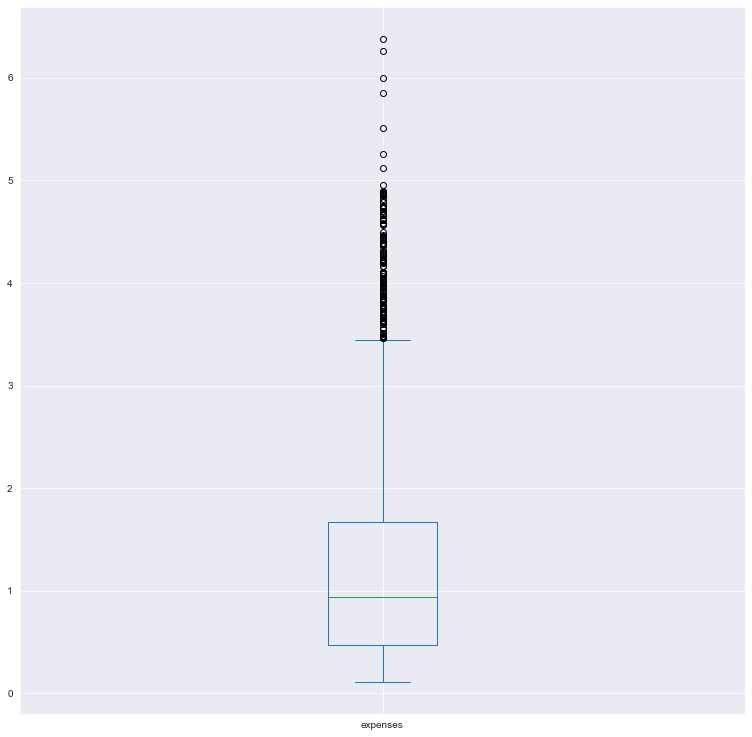

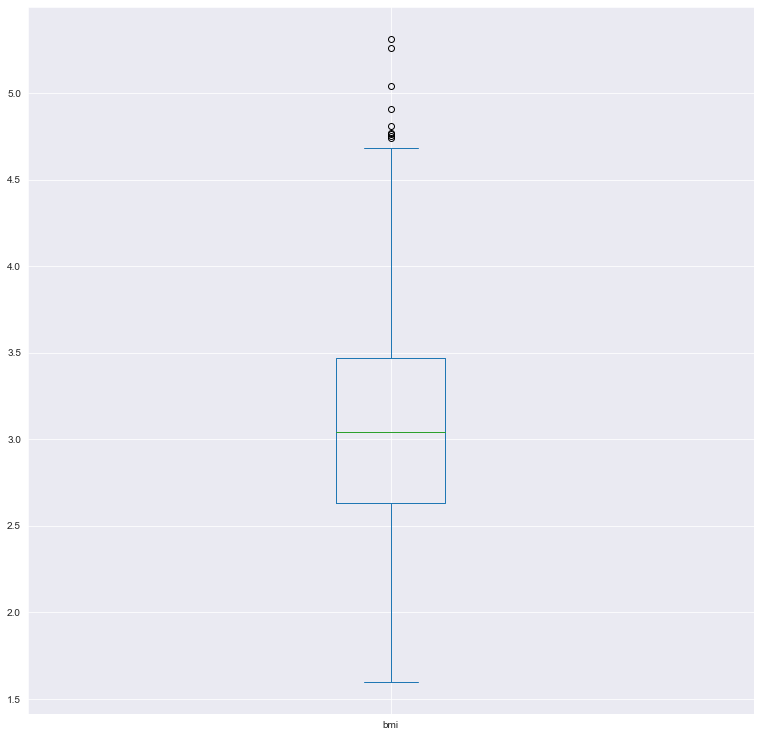

In [13]:
l_flt = ['expenses','bmi']

for q in l_flt:
    df[q].plot(kind = 'box')
    plt.show()

In [14]:
for q in l_flt:
    d = df[q].describe()
    IQR = d[-2] - d[-4]

    lower = set(np.where(df[q] < d[-4] - 1.5*IQR)[0])
    upper = set(np.where(df[q] > d[-2] + 1.5*IQR)[0])

    s_arr = list(lower.union(upper))
    df[q][s_arr] = np.nan

In [15]:
df.isnull().sum()

age           0
sex           0
bmi           9
children      0
smoker        0
region        0
expenses    139
dtype: int64

In [16]:
df['expenses'] = df['expenses'].fillna(value = df['expenses'].median())

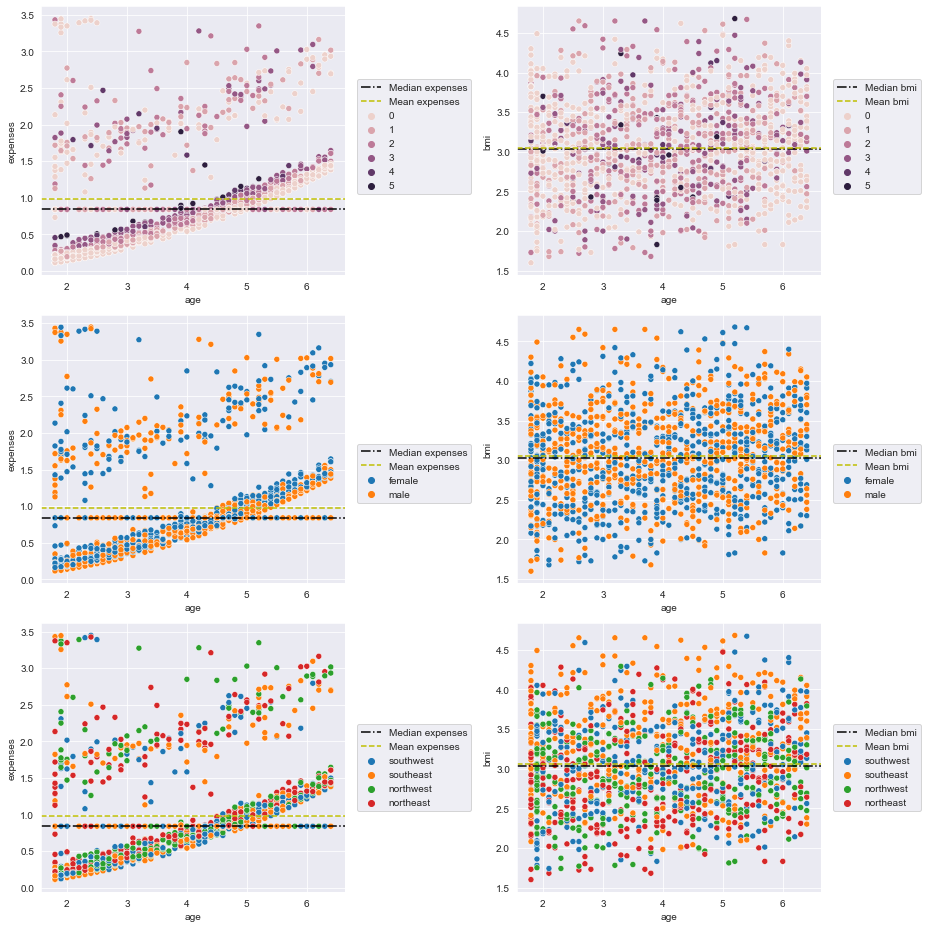

In [17]:
plt.subplot(321)
sns.scatterplot('age', 'expenses', hue = 'children', data = df)
plt.axhline(df['expenses'].median(), label = 'Median expenses',linestyle = 'dashdot', color = 'k')
plt.axhline(df['expenses'].mean(), label = 'Mean expenses', linestyle = '--', color = 'y')
plt.legend(loc = (1.04, 0.3))

plt.subplot(322)
sns.scatterplot('age', 'bmi', hue = 'children', data = df)
plt.axhline(df['bmi'].median(), label = 'Median bmi',linestyle = 'dashdot', color = 'k')
plt.axhline(df['bmi'].mean(), label = 'Mean bmi', linestyle = '--', color = 'y')
plt.legend(loc = (1.04, 0.3))

plt.subplot(323)
sns.scatterplot('age', 'expenses', hue = 'sex', data = df)
plt.axhline(df['expenses'].median(), label = 'Median expenses',linestyle = 'dashdot', color = 'k')
plt.axhline(df['expenses'].mean(), label = 'Mean expenses', linestyle = '--', color = 'y')
plt.legend(loc = (1.04, 0.3))

plt.subplot(324)
sns.scatterplot('age', 'bmi', hue = 'sex', data = df)
plt.axhline(df['bmi'].median(), label = 'Median bmi',linestyle = 'dashdot', color = 'k')
plt.axhline(df['bmi'].mean(), label = 'Mean bmi', linestyle = '--', color = 'y')
plt.legend(loc = (1.04, 0.3))

plt.subplot(325)
sns.scatterplot('age', 'expenses', hue = 'region', data = df)
plt.axhline(df['expenses'].median(), label = 'Median expenses',linestyle = 'dashdot', color = 'k')
plt.axhline(df['expenses'].mean(), label = 'Mean expenses', linestyle = '--', color = 'y')
plt.legend(loc = (1.04, 0.3))

plt.subplot(326)
sns.scatterplot('age', 'bmi', hue = 'region', data = df)
plt.axhline(df['bmi'].median(), label = 'Median bmi',linestyle = 'dashdot', color = 'k')
plt.axhline(df['bmi'].mean(), label = 'Mean bmi', linestyle = '--', color = 'y')
plt.legend(loc = (1.04, 0.3))

plt.tight_layout()

### Discrete

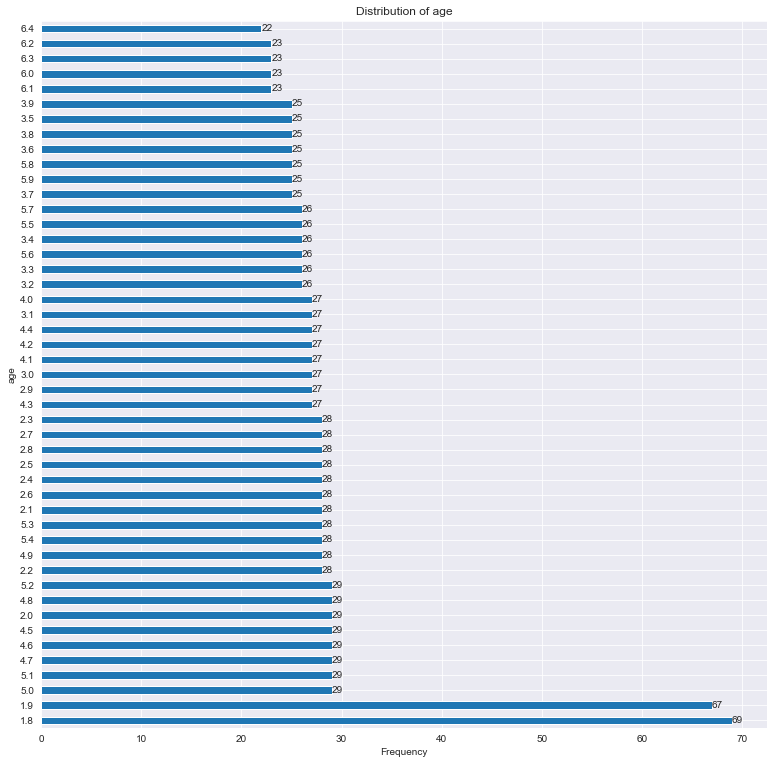

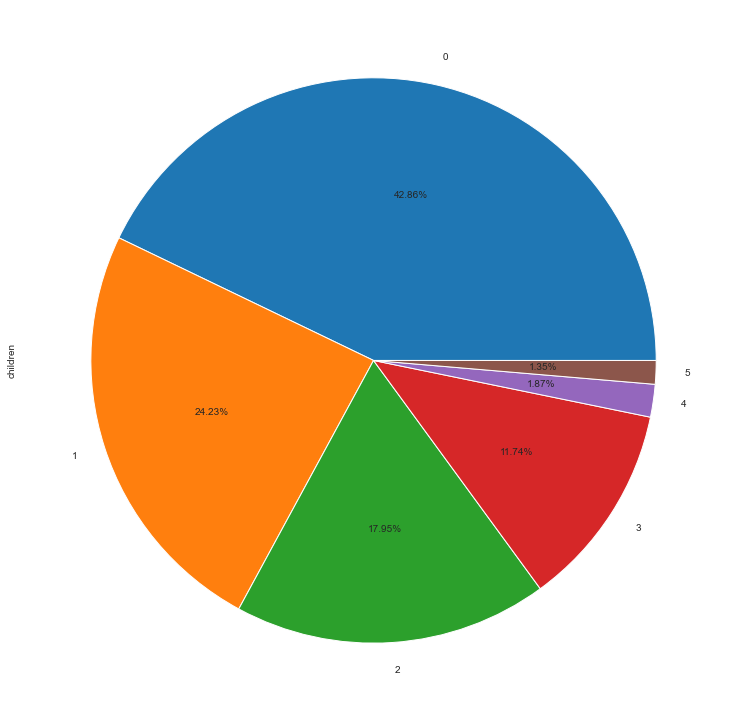

In [18]:
l_dis = ['age','children']

for w in l_dis:
    
    if len(df[w].unique()) > 10:
        ax = df[w].value_counts().plot(kind = 'barh')
        for e in ax.containers:
            ax.bar_label(e)
        plt.title(f'Distribution of {w}')
        plt.ylabel(f'{w}')
        plt.xlabel(f'Frequency')
            
    else:
        df[w].value_counts().plot(kind = 'pie', autopct = '%.2f%%')
        
    plt.show()

### Categorical

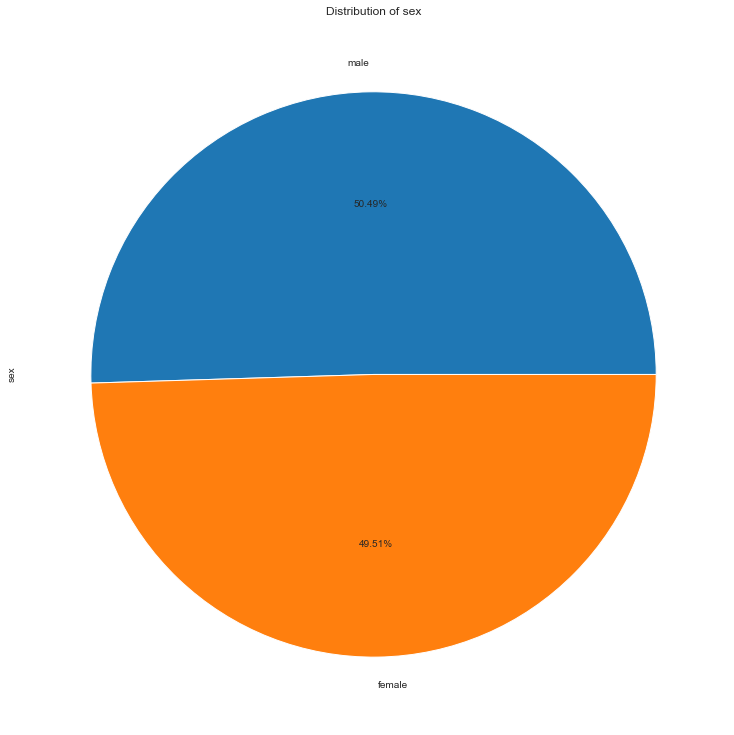

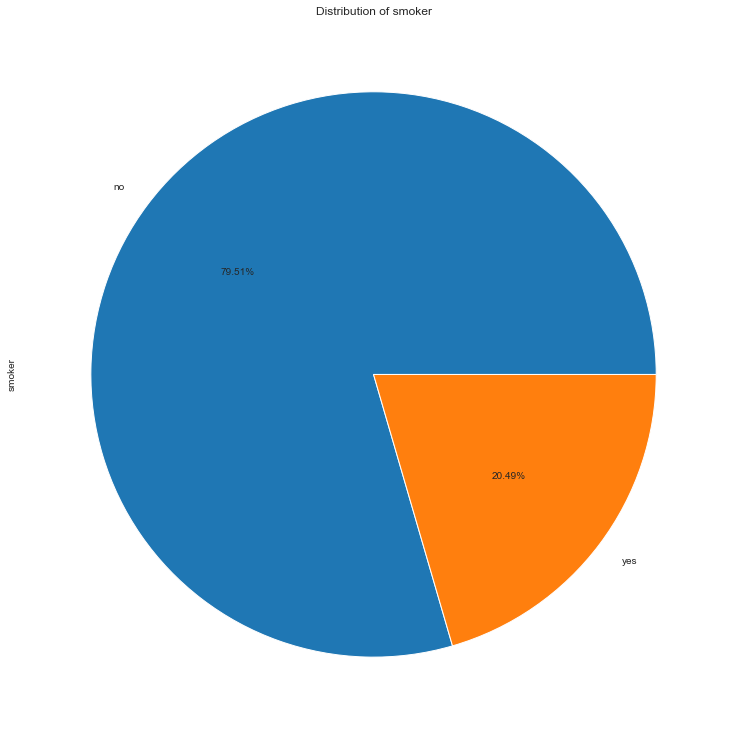

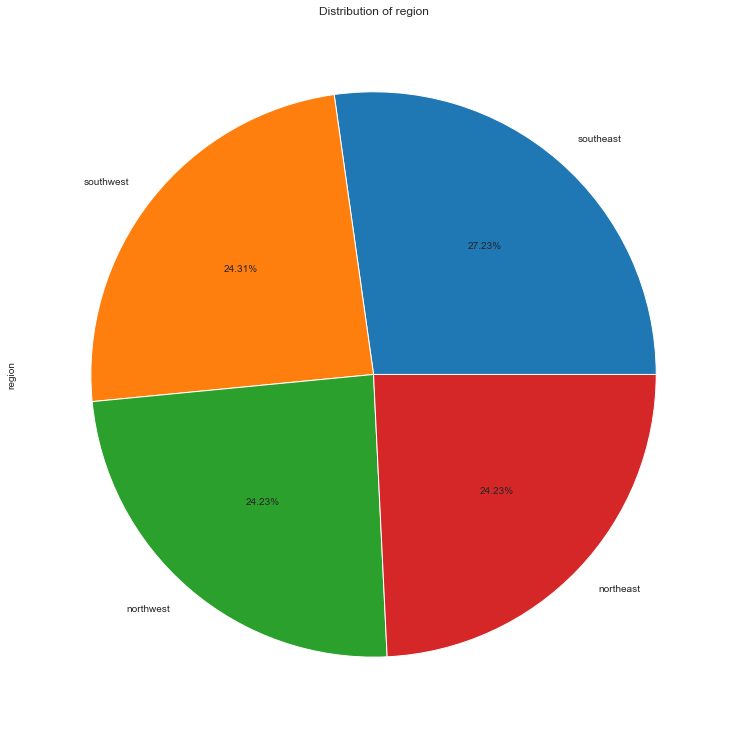

In [19]:
for e in df.dtypes[df.dtypes == 'object'].index.tolist():
    df[e].value_counts().plot(kind = 'pie', autopct = '%.2f%%')
    plt.title(f'Distribution of {e}')
    plt.show()

### Performing encoding

In [20]:
for r in df.dtypes[df.dtypes == 'object'].index.tolist():
    print(f'In {r}:')
    for t,u in enumerate(sorted(df[r].unique())):    
        print(f'{u} will be replaced by {t}.')
    print('\n')

In sex:
female will be replaced by 0.
male will be replaced by 1.


In smoker:
no will be replaced by 0.
yes will be replaced by 1.


In region:
northeast will be replaced by 0.
northwest will be replaced by 1.
southeast will be replaced by 2.
southwest will be replaced by 3.




In [21]:
for o in df.dtypes[df.dtypes == 'object'].index.tolist():
    df[o] = df[o].astype('category').cat.codes

In [22]:
df

,age,sex,bmi,children,smoker,region,expenses
0,1.9,0,2.79,0,1,3,1.688492
1,1.8,1,3.38,1,0,2,0.172555
2,2.8,1,3.30,3,0,2,0.444946
3,3.3,1,2.27,0,0,1,2.198447
4,3.2,1,2.89,0,0,1,0.386686
...,...,...,...,...,...,...,...
1332,5.0,1,3.10,3,0,1,1.060055
1333,1.8,0,3.19,0,0,0,0.220598
1334,1.8,0,3.69,0,0,2,0.162983
1335,2.1,0,2.58,0,0,3,0.200795


### Feature Selection and Feature Engineering 

<AxesSubplot:>

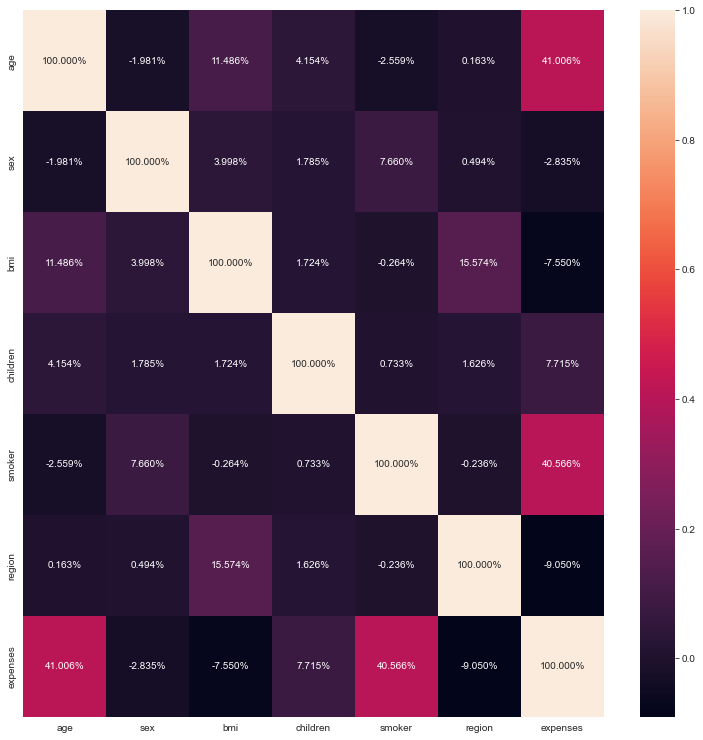

In [23]:
sns.heatmap(df.corr(), annot = True, fmt='.3%')

In [24]:
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import scale

from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor

In [25]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

In [26]:
clean_dataset(df)

,age,sex,bmi,children,smoker,region,expenses
0,1.9,0.0,2.79,0.0,1.0,3.0,1.688492
1,1.8,1.0,3.38,1.0,0.0,2.0,0.172555
2,2.8,1.0,3.30,3.0,0.0,2.0,0.444946
3,3.3,1.0,2.27,0.0,0.0,1.0,2.198447
4,3.2,1.0,2.89,0.0,0.0,1.0,0.386686
...,...,...,...,...,...,...,...
1332,5.0,1.0,3.10,3.0,0.0,1.0,1.060055
1333,1.8,0.0,3.19,0.0,0.0,0.0,0.220598
1334,1.8,0.0,3.69,0.0,0.0,2.0,0.162983
1335,2.1,0.0,2.58,0.0,0.0,3.0,0.200795


In [27]:
x = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [28]:
model_lr = LinearRegression()
model_knn = KNeighborsRegressor()

model_svr = SVR()
model_dt = DecisionTreeRegressor()

model_rf = RandomForestRegressor()
model_gbr = GradientBoostingRegressor()

model_xgb = xgb.XGBRegressor()
model_xgbrf = xgb.XGBRFRegressor()

model_abr = AdaBoostRegressor()
model_etr = ExtraTreesRegressor()

model_hgr = HistGradientBoostingRegressor()
model_lgb = lgbm.LGBMRegressor()

In [29]:
l_model = [model_lr, model_knn, model_svr, model_dt, model_rf, model_gbr,
           model_xgbrf, model_xgb, model_abr, model_etr, model_hgr, model_lgb]

l_names = ['LinearRegression()','KNeighborsRegressor()','SVR()','DecisionTreeRegressor()','RandomForestRegressor()',
          'GradientBoostingRegressor()','XGBRFRegressor()','XGBRegressor()','AdaBoostRegressor()','ExtraTreesRegressor()',
          'HistGradientBoostingRegressor()','LGBMRegressor()']

In [30]:
x_train, x_test, y_train, y_test = train_test_split(x,y,random_state=0)

In [31]:
df_model = pd.DataFrame()
c = 1

while c <= len(l_model):

    l_model[c-1].fit(x_train, y_train)
    df_model[str(l_names[c-1])] = l_model[c-1].predict(x_test)
    c += 1
    
df_model

,LinearRegression(),KNeighborsRegressor(),SVR(),DecisionTreeRegressor(),RandomForestRegressor(),GradientBoostingRegressor(),XGBRFRegressor(),XGBRegressor(),AdaBoostRegressor(),ExtraTreesRegressor(),HistGradientBoostingRegressor(),LGBMRegressor()
0,0.431663,0.198584,0.291052,0.210308,0.255167,0.251924,0.345654,0.190537,0.706759,0.219517,0.157286,0.167397
1,0.802136,0.605514,0.679587,0.541566,0.668233,0.752219,0.647217,1.016925,0.978289,0.633946,1.002774,1.038330
2,1.512451,1.067520,1.203849,3.278746,1.838462,1.949445,1.680485,2.454143,1.538825,1.254473,1.728355,2.228724
3,1.817865,0.841175,1.254974,0.841175,0.841176,0.923678,0.880402,0.813650,0.841175,0.841176,0.885508,0.861485
4,1.241656,1.165801,1.127341,0.999104,1.457745,1.351852,1.389704,1.448809,1.603085,1.851611,1.181548,1.114306
...,...,...,...,...,...,...,...,...,...,...,...,...
327,1.051366,0.970760,1.031312,0.938616,1.147687,1.086762,1.155791,1.455870,1.365325,0.998361,1.039186,0.964996
328,1.885557,0.953366,1.137936,0.841175,0.841176,0.878300,0.912953,1.106681,0.841175,0.858073,1.170725,1.177123
329,0.395657,0.160410,0.223815,0.124226,0.126955,0.102917,0.227932,0.095665,0.590642,0.124256,-0.031219,0.019716
330,1.609513,0.841175,1.021424,0.841175,0.839780,0.803476,0.858496,0.877539,0.841175,0.841176,1.047379,1.007715


In [32]:
c = 1

while c <= len(l_model):
    
    print(f'For {l_names[c-1]}:')
    print(f'R2: {r2_score(y_test, df_model[str(l_names[c-1])])}')
    print(f'MAE: {mean_absolute_error(y_test, df_model[str(l_names[c-1])])}')
    print(f'MSE: {mean_squared_error(y_test, df_model[str(l_names[c-1])])}')
    print(f'RMSE: {np.power(mean_squared_error(y_test, df_model[str(l_names[c-1])]), 1/2)}')
    print('\n')
    
    c += 1

For LinearRegression():
R2: 0.3251996395087676
MAE: 0.3647012204823665
MSE: 0.32787514555728786
RMSE: 0.5726038294993213


For KNeighborsRegressor():
R2: 0.3214814219043105
MAE: 0.3389813246987952
MSE: 0.32968177046393077
RMSE: 0.5741792145871625


For SVR():
R2: 0.4314135321042166
MAE: 0.2744980074081926
MSE: 0.27626744417789384
RMSE: 0.5256114954773096


For DecisionTreeRegressor():
R2: 0.21706251846518698
MAE: 0.2684253057228917
MSE: 0.3804173141425264
RMSE: 0.6167797938831382


For RandomForestRegressor():
R2: 0.5202597349138998
MAE: 0.25963530499497994
MSE: 0.23309843689219653
RMSE: 0.48280268940033516


For GradientBoostingRegressor():
R2: 0.556741337840233
MAE: 0.2553284421184621
MSE: 0.21537258555903008
RMSE: 0.46408252020414437


For XGBRFRegressor():
R2: 0.5635410086617945
MAE: 0.2515102876373257
MSE: 0.21206872979532226
RMSE: 0.4605092070690034


For XGBRegressor():
R2: 0.43238515960961166
MAE: 0.31011868042985574
MSE: 0.2757953452751503
RMSE: 0.5251622085367057


For AdaBoo

### Smaller MAE and greater R2 score indicate a good model. So here XGBRFRegressor() is the best model. Saving and calling the model to make predictions:

In [33]:
import joblib 
joblib.dump(model_xgbrf,'insurance_premium_model.pkl.pkl') # .pkl pickle

['insurance_premium_model.pkl.pkl']

In [34]:
xgbrf_from_joblib = joblib.load('insurance_premium_model.pkl.pkl')

In [35]:
x_random_sample = x.sample(1)
x_random_sample

,age,sex,bmi,children,smoker,region
597,4.3,1,3.26,2,0,3


In [36]:
xgbrf_from_joblib.predict(x_random_sample)*10000

array([9185.565], dtype=float32)